### Предлагаю Вам выполнить следующее тестовое задание.<br> 
Необходимо натренировать нейронную сеть, которая на вход будет принимать картинку со словом, а на выходе - определяет шрифт, которым написан текст. <br> 
Для начала возьмите порядка 10 разных шрифтов. <br> 
Датасеты для обучения и валидации Вам предлагается сгенерировать самостоятельно. <br> 
Фреймворк для обучения сети - TensorFlow, язык скриптов - Python. <br> Оформление задачи в виде Jupyter notebook приветствуется. 

<br> 
##### Выполнил: Евгений Сорока 

In [40]:
import tensorflow as tf

import numpy as np
from scipy.misc import imresize

import matplotlib.pyplot as plt
from matplotlib import rcParams
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

plt.style.use('ggplot')
#rcParams['figure.figsize'] = 10, 8
seed = 256

%matplotlib inline

Загрузим сгенированный датасет. 
Датасет включает в себя 1300 уникальных слов, каждое слово имеет 10 различных написаний, в зависимости от шрифта.
Используемые шрифты: 
<li>arial
<li>bookman
<li>calibri
<li>century
<li>comic
<li>dotum
<li>georgia
<li>gost
<li>tahoma
<li>times new roman


In [41]:
directory = os.listdir('data/')

fonts = [os.path.join('data', d+'/') for d in os.listdir('data/')]
data_links = sorted([os.path.join(f, i) for f in fonts for i in os.listdir(f)])

len(data_links)

13000

In [42]:
labels = np.array([np.zeros(1300, dtype=np.int32)+i for i in range(0, 10)]).flatten()
labels.shape

(13000,)

In [43]:
data_raw = np.array([io.imread(img, as_grey=True).astype(np.float32) for img in data_links])

Преообразуем изображения к единому виду.

In [44]:
data = np.array([imresize(img, (28, 126)) for img in data_raw])
data = np.array([img[:,:-26] for img in data])

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [45]:
%store data_raw
del data_raw

Stored 'data_raw' (ndarray)


In [46]:
data.shape

(13000, 28, 100)

Посмотрим как выглядят обьекты

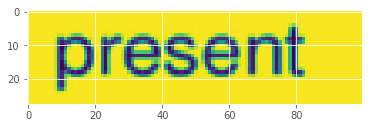

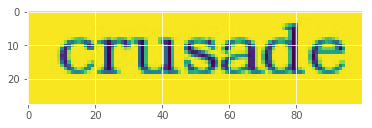

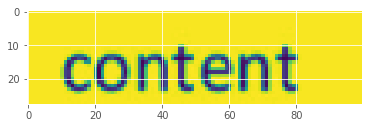

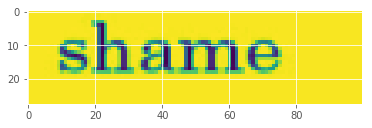

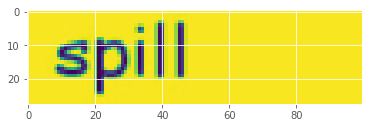

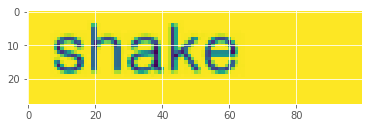

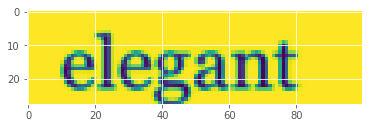

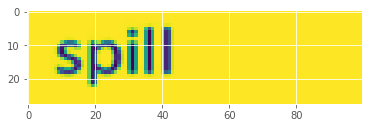

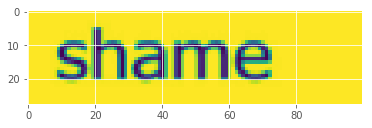

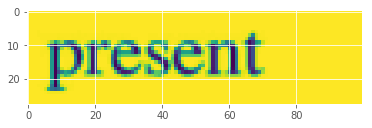

In [47]:
for i in np.linspace(0, 13000, 10, endpoint=False, dtype=np.int32):
    plt.figure()
    plt.imshow(data[i])

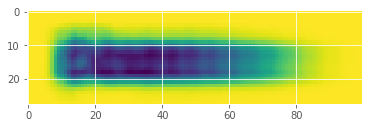

In [48]:
mean = data.mean(axis=0)
plt.imshow(mean)

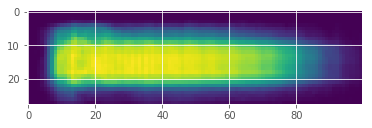

In [49]:
stddev = data.std(axis=0)
plt.imshow(stddev)

Преобразуем целевые переменные в бинарный формат

In [50]:
def onehot(y):
    a = np.zeros((y.shape[0], 10))
    a[np.arange(y.shape[0]), y] = 1
    print(a[0])
    return a

y = onehot(labels)
y.shape

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(13000, 10)

In [56]:
#%store -r data
train = data[:,:,:,np.newaxis] / 255
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=32)
print(X_train.shape)
print(X_test.shape)
print(np.sum(y_train, axis=0))


(10400, 28, 100, 1)
(2600, 28, 100, 1)
[1052. 1008. 1056. 1050. 1047. 1038. 1013. 1029. 1053. 1054.]


In [57]:
%store data
del data

Stored 'data' (ndarray)


Построим модель подходом библиотеки Keras, но на Tensorflow

In [70]:
model = tf.keras.Sequential(name='CNN')
model.add(tf.keras.layers.Conv2D(32, kernel_size=(4, 4),
                                 activation='relu',
                                 input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (4, 4), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 25, 97, 32)        544       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 94, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 47, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 11, 47, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 33088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)              67766272  
_________________________________________________________________
dense_17 (Dense)             (None, 256)               524544    
__________

In [71]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [72]:
# Изменил размер пакета с 256 на 128, чтобы более точно найти глобальный минимум градиента.
n_epochs = 12
batch_size = 128

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10400 samples, validate on 2600 samples
Epoch 1/12
10400/10400 [==============================] - 175s 17ms/step - loss: 1.8796 - acc: 0.3438 - val_loss: 1.1728 - val_acc: 0.5604
Epoch 2/12
10400/10400 [==============================] - 174s 17ms/step - loss: 0.7906 - acc: 0.7270 - val_loss: 0.5422 - val_acc: 0.7977
Epoch 3/12
10400/10400 [==============================] - 174s 17ms/step - loss: 0.4335 - acc: 0.8569 - val_loss: 0.2108 - val_acc: 0.9308
Epoch 4/12
10400/10400 [==============================] - 174s 17ms/step - loss: 0.1903 - acc: 0.9346 - val_loss: 0.1618 - val_acc: 0.9492
Epoch 5/12
10400/10400 [==============================] - 173s 17ms/step - loss: 0.1101 - acc: 0.9642 - val_loss: 0.0933 - val_acc: 0.9677
Epoch 6/12
10400/10400 [==============================] - 173s 17ms/step - loss: 0.0736 - acc: 0.9762 - val_loss: 0.0773 - val_acc: 0.9719
Epoch 7/12
10400/10400 [==============================] - 173s 17ms/step - loss: 0.1747 - acc: 0.9587 - val_loss: 0.1

Сохраним модель и полученные веса


In [73]:
model.save_weights("weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [74]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_test = np.argmax(y_test, 1)

Построим confusion matrix и classification report

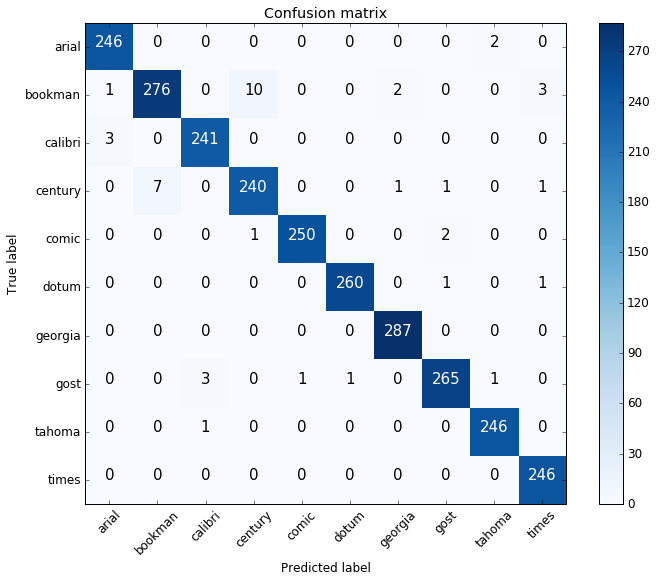

In [75]:
import itertools

cmatrix = confusion_matrix(y_test, y_pred)
classes = ['arial', 'bookman', 'calibri', 'century', 'comic', 'dotum', 'georgia', 'gost', 'tahoma', 'times'] 

def plot_confusion_matrix(cmatrix, classes, cmap=plt.cm.Blues):

    #print(cmatrix)
    plt.style.use('classic')
    plt.imshow(cmatrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, format(cmatrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black", fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plt.figure(figsize=(10,8))
plot_confusion_matrix(cmatrix, classes)    

In [76]:
print(classification_report(y_test, y_pred, target_names=classes))

             precision    recall  f1-score   support

      arial       0.98      0.99      0.99       248
    bookman       0.98      0.95      0.96       292
    calibri       0.98      0.99      0.99       244
    century       0.96      0.96      0.96       250
      comic       1.00      0.99      0.99       253
      dotum       1.00      0.99      0.99       262
    georgia       0.99      1.00      0.99       287
       gost       0.99      0.98      0.98       271
     tahoma       0.99      1.00      0.99       247
      times       0.98      1.00      0.99       246

avg / total       0.98      0.98      0.98      2600



In [77]:
fp_indeces = (~(y_test == y_pred)).nonzero()[0]

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


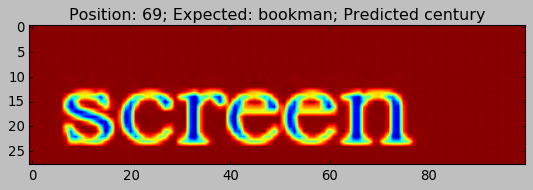

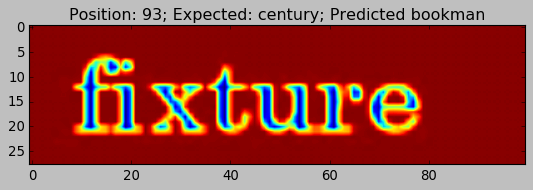

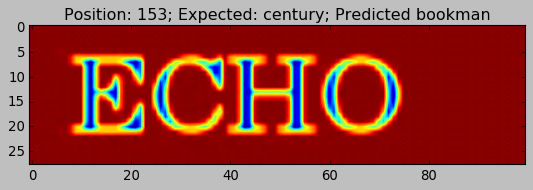

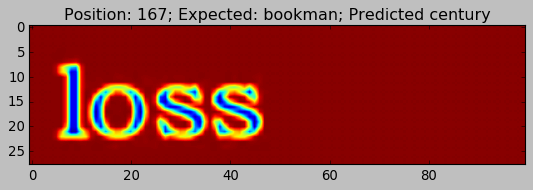

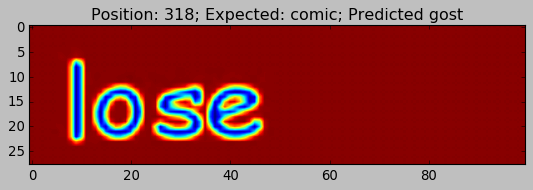

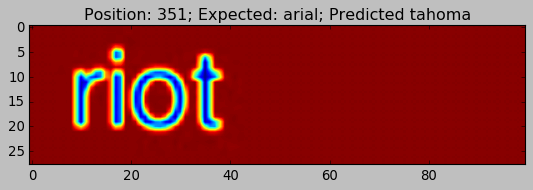

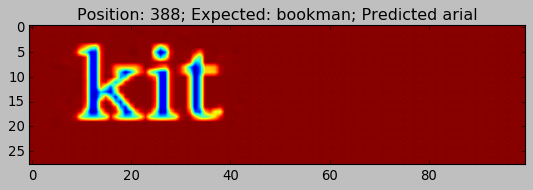

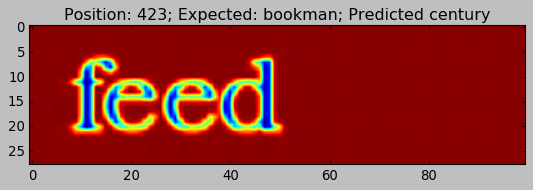

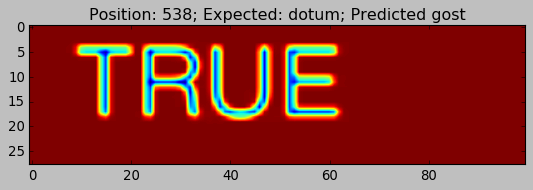

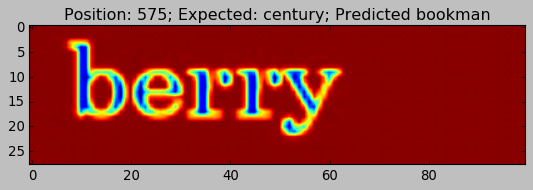

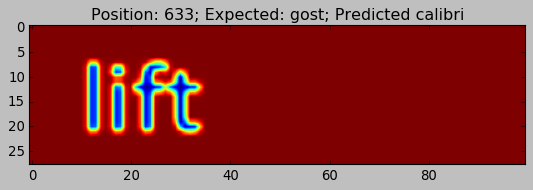

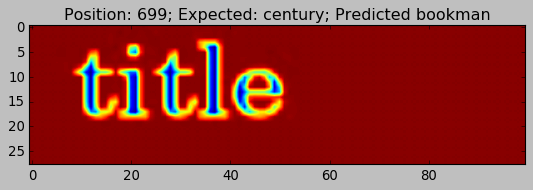

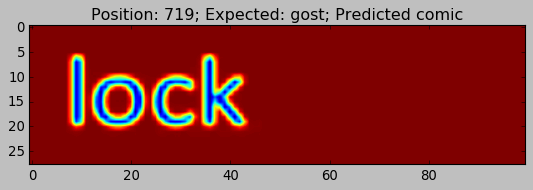

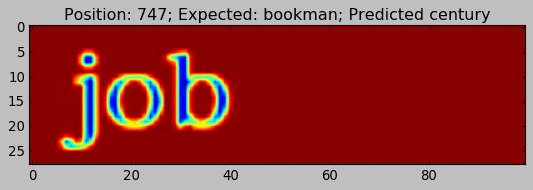

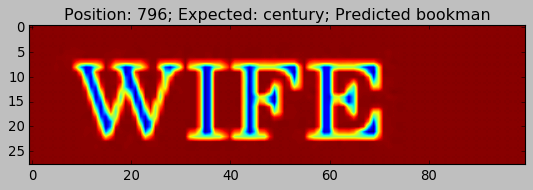

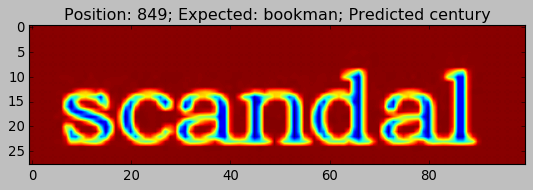

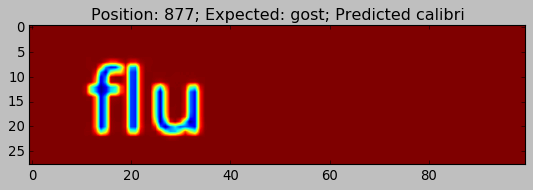

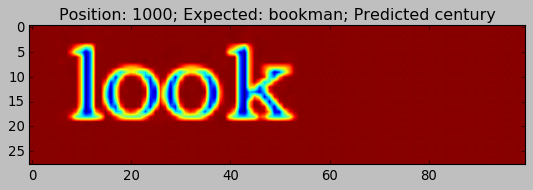

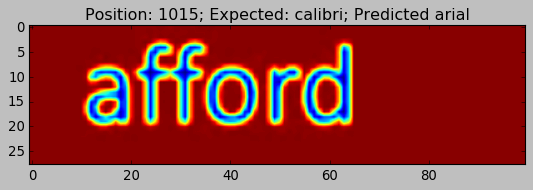

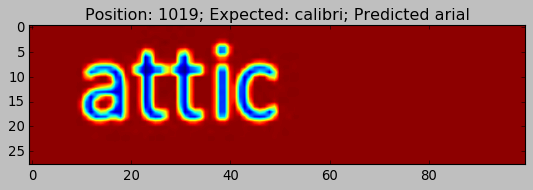

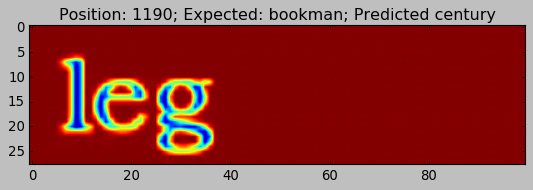

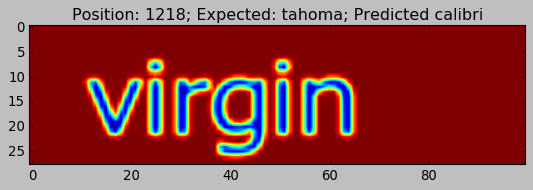

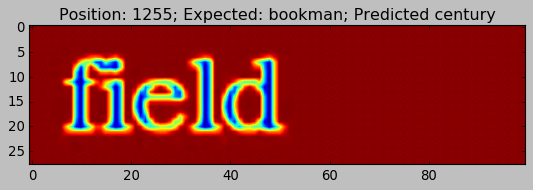

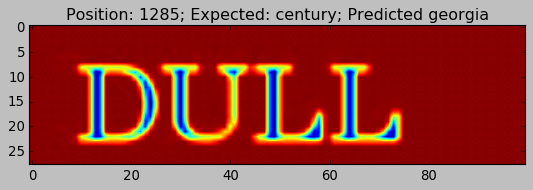

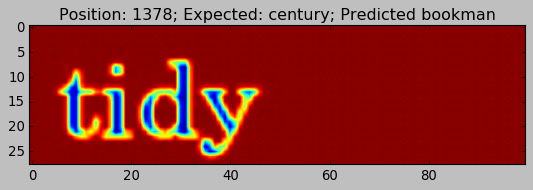

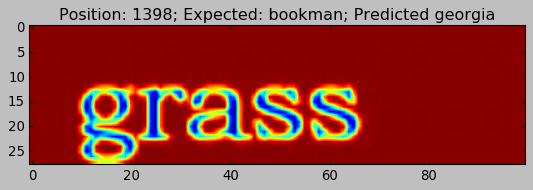

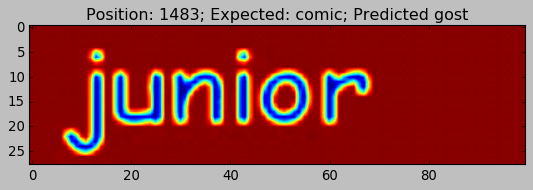

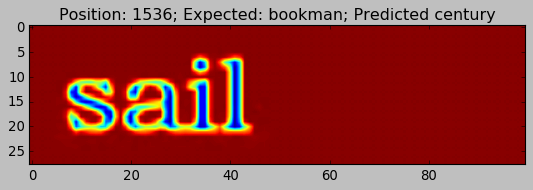

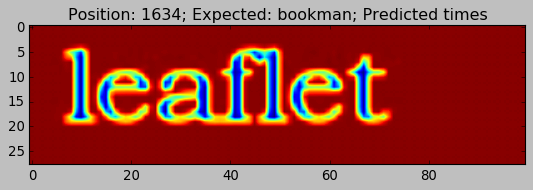

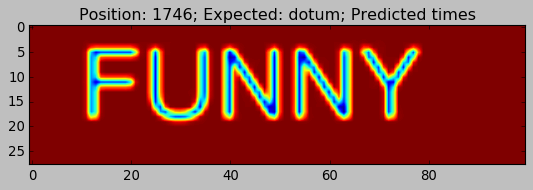

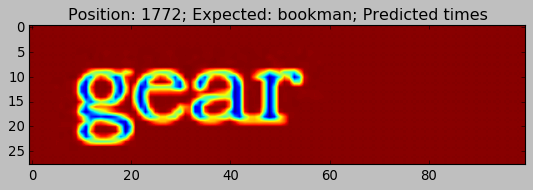

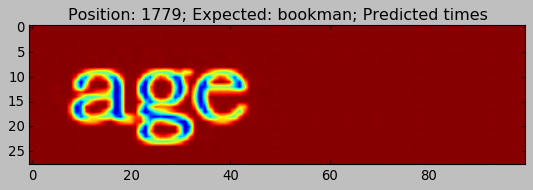

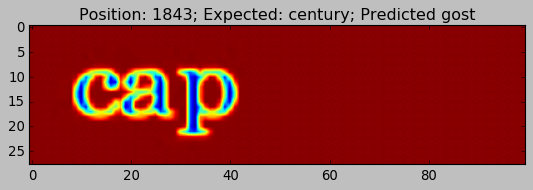

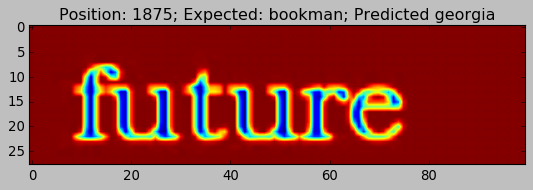

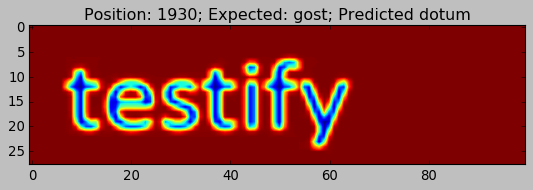

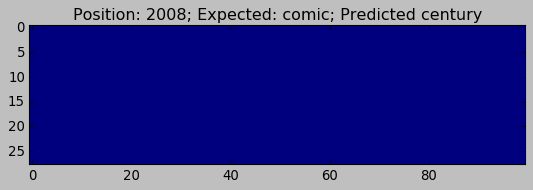

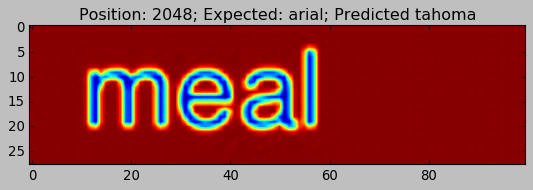

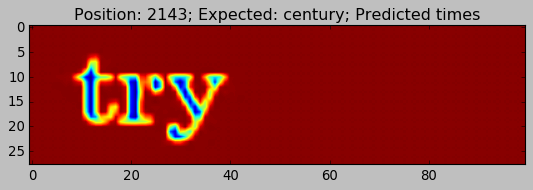

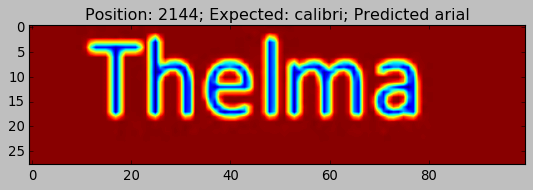

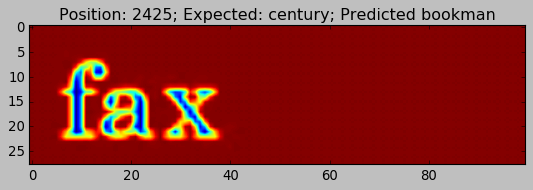

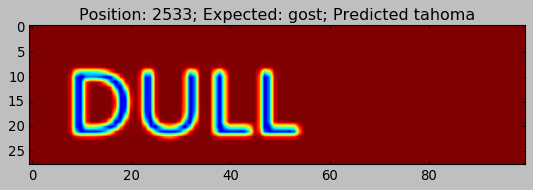

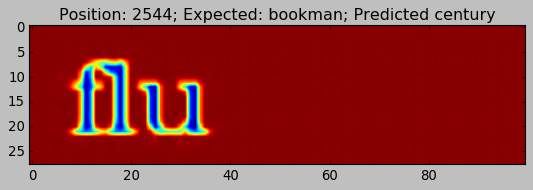

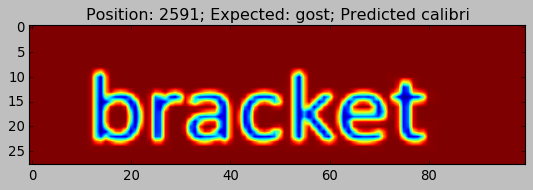

In [78]:
def plot_fp_results(indeces, classes):
    
    for i in indeces:
        plt.figure()
        plt.imshow(np.reshape(X_test[i], (28, 100)))
        plt.title('Position: {}; Expected: {}; Predicted {}'.format(i, classes[y_test[i]], classes[y_pred[i]]))

plot_fp_results(fp_indeces, classes)        

In [79]:
def load_model_from_json(model_path, weights_path=None):
    
    with open(model_path, 'r') as json_file:
        loaded_model_json = json_file.read()
    
    model = tf.keras.models.model_from_json(loaded_model_json)
    
    print("Loaded model from disk")
    
    if weights_path:
        model.load_weights(weights_path)
    
        print("Loaded pretrained weights for model")
        
    return model
    
          

In [81]:
#y_test = onehot(y_test)
m = load_model_from_json('model.json', 'weights.h5')
m.compile(loss=tf.keras.losses.categorical_crossentropy, 
           optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])

print('Prediction...')

score = m.evaluate(X_test, y_test, verbose=1)

print("%s: %.2f%%" % (m.metrics_names[1], score[1]*100))

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Loaded model from disk
Loaded pretrained weights for model
Prediction...
2600/2600 [==============================] - 13s 5ms/step
acc: 98.35%


In [86]:
!pip freeze > requirements.txt